In [10]:
# Setup Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Global imports
import csv
import cv2
import json
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns

# Typing import
from typing import List, Dict, Union, Tuple

# Specific imports
from copy import deepcopy
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.animation import FuncAnimation, PillowWriter
from rich import print
from termcolor import cprint
from time import time

# Local imports
from read_csv import read_meta_info

sns.set_theme('notebook')
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

def print_bl():
    print("\n")


def print_red(*args):
    for arg in args:
        cprint(arg, "red", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_green(*args):
    for arg in args:
        cprint(arg, "green", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_highlight(*args):
    for arg in args:
        cprint(arg, "magenta", "on_white", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_blue(*args):
    for arg in args:
        cprint(arg, "light_blue", end=' ')  # Using end=' ' to print all arguments on the same line
    print()


Group definition:
- 1 second sampling rate.
- In any scene, choose an ego vehicle __outside__ of the roundabout. That is the ego vehicle.
    - Sample the database until the ego vehicle enters the roundabout
    - If window length is short, resample the same scene with another ego_vehicle. If there are not any suitable vehicles, move on.
- Max window length: 5 seconds.

Refer all coordinates to the center of the roundabout. Perform calculations in pixels and then convert to meters using OrthoPxToMeter*10.

In [18]:
class RounDGroupExtractor:
    """
    A class that extracts vehicle groups from a highD dataset recording
    
    Attributes:
        dataset_location: a path to the directory in which the dataset is stored.
        dataset_index: index of the recording that is to be addressed
        data: the raw data of the recording.
        static_info: the static information of the recording.
        video_info: the video information of the recording.

    Methods:        
        get_background_img: sets the background image for plotting, creating gifs, and calculating roundabout geometry.
    """
    def __init__(self, dataset_location: str = None, dataset_index: int = None):
        """
        Initializes the PromptExtractor class.

        Args:
            dataset_location (str): The path to the directory in which the dataset is stored.
            dataset_index (int): The index of the recording that is to be addressed.
        """
        ### Error handling
        if dataset_location is None:
            raise ValueError("Please provide a dataset location.")
        if dataset_index is None or dataset_index < 1 or dataset_index > 22:
            raise ValueError("Please provide a dataset index between 1 and 22")
        
        # retrieve raw data
        self.dataset_index  = dataset_index
        self.dataset_location = dataset_location
        self.df_location = dataset_location + str(dataset_index).zfill(2) + "_tracks.csv"
        self.static_info_location = dataset_location + str(dataset_index).zfill(2) + "_tracksMeta.csv"
        self.video_info_location = dataset_location + str(dataset_index).zfill(2) + "_recordingMeta.csv"
        
        def csv_to_dict(filename: str) -> Dict[str, Union[int, float, str]]:
            def convert_value(value: str) -> Union[int, float, str]:
                """Helper function to convert values to the appropriate data type."""
                try:
                    # Try to convert to an integer
                    if '.' not in value:
                        return int(value)
                    # Try to convert to a float if it's not an int
                    return float(value)
                except ValueError:
                    # If it fails to convert, return as string
                    return value
                
            with open(filename, mode='r') as csv_file:
                csv_reader = csv.DictReader(csv_file)
                first_row = next(csv_reader)
                return {key: convert_value(value) for key, value in first_row.items()}
                
        self.data = pd.read_csv(self.df_location)
        self.static_info = pd.read_csv(self.static_info_location)
        self.video_info = csv_to_dict(self.video_info_location)

        self.frame_length = 1000/self.video_info["frameRate"] # Measured in miliseconds

        self.get_background_img(dataset_location + str(dataset_index).zfill(2) + "_background.png")
        self.center_x_px, self.center_y_px, self.outer_radius_px, self.inner_radius_px = self.get_roundabout_edges(plot_results=False)
        self.center_x_m = self.center_x_px * self.bg_image_scaling_factor * 10
        self.center_y_m = -self.center_y_px * self.bg_image_scaling_factor * 10
        self.outer_radius_m = self.outer_radius_px * self.bg_image_scaling_factor * 10
        self.inner_radius_m = self.inner_radius_px * self.bg_image_scaling_factor * 10

        # print_green(f"Roundabout center: ({self.center_x_m:.2f}, {self.center_y_m:.2f}) m")
        # print_green(f"Roundabout outer radius: {self.outer_radius_m:.2f} m")
        # print_green(f"Roundabout inner radius: {self.inner_radius_m:.2f} m")

        ## Initialize parameters
        self.sampling_period = None
        self.frame_spacing = None
        self.raw_frames = None
        self.framing_dict = None
 
    def get_background_img(self, path) -> None:
        '''
        Sets the background image for plotting and creating gifs.
            Parameters:
                path (str): path to the png file that contains the background image
            Returns:
                Nothing
        '''
        self.bg_image = cv2.imread(path)
        self.bg_image_scaling_factor = self.video_info["orthoPxToMeter"] # Measured in meters per pixel

    def get_roundabout_edges(self, plot_results: bool = False) -> Tuple[int, int, int, int]:
        """
        Detects both the outer and inner edges of the roundabout using HoughCircles.
        Displays the original image, grayscale image, blurred image, and detected circles.

        The function first detects the outer edge of the roundabout using a larger radius range. 
        When the outer edge is detected, the function restricts the radius range to detect the inner edge. 
        The function then calculates the average of the centers of the inner and outer circles to determine the center of the roundabout.

        Args:
            plot_results (bool): Whether to plot the results or not.

        Returns:
            center_x (int): X-coordinate of the center of the average of the inner and outer circles.
            center_y (int): Y-coordinate of the center of the average of the inner and outer circles.
            outer_radius (int): Radius of the outer circle.
            inner_radius (int): Radius of the inner circle.

        """
        ### Error handling
        if not hasattr(self, "bg_image"):
            raise ValueError("Please set the background image first.")
        
        image = self.bg_image
        original_image = image.copy()
        
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply a Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (9, 7), 0)
    
        # Use HoughCircles to detect outer circles
        outer_circles = cv2.HoughCircles(
            blurred, 
            cv2.HOUGH_GRADIENT, 
            dp=1.2, 
            minDist=1000,  
            param1=100,  
            param2=30,  
            minRadius=200,  
            maxRadius=300  
        )
        
        if outer_circles is not None:
            outer_circles = np.round(outer_circles[0, :]).astype("int")
            largest_circle = max(outer_circles, key=lambda x: x[2])  # Select the largest circle (outer edge)
            
            center_x, center_y, outer_radius = largest_circle
            
            # Create a copy of the image for visualizing both inner and outer edges
            edge_image = original_image.copy()
            
            # Draw the largest outer circle
            cv2.circle(edge_image, (center_x, center_y), outer_radius, (0, 255, 0), 4)  # Outer circle in green
            cv2.circle(edge_image, (center_x, center_y), 5, (255, 0, 0), -1)  # Center point in blue
            
            #print(f"Largest outer circle center: (X: {center_x}, Y: {center_y}), Radius: {outer_radius} px")
            
            # Now detect inner circles by restricting the maxRadius and using the same center
            inner_circles = cv2.HoughCircles(
                blurred, 
                cv2.HOUGH_GRADIENT, 
                dp=1, 
                minDist=300,  
                param1=100,  
                param2=30,  
                minRadius=100,  # Smaller minimum radius for inner circles
                maxRadius=outer_radius - 50  # Restrict max radius to be smaller than the outer circle
            )
            
            # Plot the original image, grayscale, and blurred image in a 2x2 subplot layout
            if plot_results:
                fig, axs = plt.subplots(2, 2, figsize=(10, 10))
                
                axs[0, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                axs[0, 0].set_title('Original Image')
                
                axs[0, 1].imshow(gray, cmap='gray')
                axs[0, 1].set_title('Grayscale Image')
                
                axs[1, 0].imshow(blurred, cmap='gray')
                axs[1, 0].set_title('Blurred Image')
            
            if inner_circles is not None:
                inner_circles = np.round(inner_circles[0, :]).astype("int")
                
                # Draw all detected inner circles inside the outer circle
                for (x, y, r) in inner_circles:
                    cv2.circle(edge_image, (x, y), r, (255, 0, 0), 3)  # Inner circles in red
                
                # Select the closest inner circle to the center of the outer circle
                inner_center_x, inner_center_y, inner_radius = min(inner_circles, key=lambda x: abs(x[0] - center_x) + abs(x[1] - center_y))
                
                # Draw the selected inner circle
                cv2.circle(edge_image, (inner_center_x, inner_center_y), inner_radius, (0, 0, 255), 4)  # Inner circle in blue
                #print(f"Largest inner circle center: (X: {inner_center_x}, Y: {inner_center_y}), Radius: {inner_radius} px")

                # Calculate average of centers
                center_x = (center_x + inner_center_x) // 2
                center_y = (center_y + inner_center_y) // 2
                
                if plot_results:
                    # Plot the image with both outer and inner circles
                    axs[1,1].imshow(cv2.cvtColor(edge_image, cv2.COLOR_BGR2RGB))
                    axs[1,1].set_title(f'Detected Circles: Outer ({center_x}, {center_y}), Inner ({inner_center_x}, {inner_center_y})')
            else:
                if plot_results:
                    axs[1,1].text(0.5, 0.5, 'No inner circles detected', ha='center', va='center', fontsize=12)
                raise ValueError("No inner circles were detected using HoughCircles.")

            if plot_results:            
                # Show the original image and transformations
                plt.tight_layout()
                plt.show()
            
        else:
            raise ValueError("No outer edge was detected using HoughCircles.")
        
        return center_x, center_y, outer_radius, inner_radius
    
    def in_roundabout(self, x: float, y: float) -> bool:
        """
        Checks if a point is inside the roundabout.
        
        Args:
            x (float): X-coordinate of the point.
            y (float): Y-coordinate of the point.
        
        Returns:
            bool: True if the point is inside the roundabout, False otherwise.
        """
        distance_to_center = np.linalg.norm(np.array([x, y]) - np.array([self.center_x_m, self.center_y_m]))
        return self.inner_radius_m <= distance_to_center <= self.outer_radius_m
    
    def filter_data(self, sampling_period: int = 1000) -> pd.DataFrame:
        """
        Filters the dataset with a certain sampling period.

        Args:
            sampling_period (int): The time spacing between each frame to consider. Measured in ms.
        Returns:
            The filtered dataset in the form of a pandas dataframe.
        """
        ### Argument validation
        if sampling_period % self.frame_length != 0:
            raise ValueError("Sampling period must be a multiple of 40ms.")
        
        self.sampling_period = sampling_period
        self.frame_spacing = int(self.sampling_period / self.frame_length) #Frames are 40 ms apart

        ### Printing parameters
        print("Filtering data with the following parameters:")
        print_green(f"Sampling period: {self.sampling_period} ms")
        print_green(f"Frame spacing: {self.frame_spacing} frames")

        self.data = self.data[self.data.frame % self.frame_spacing == 0]
        self.raw_frames = deepcopy(self.data.frame) # copy the old frame numbering for animation purposes
        self.data.frame = self.data.frame / self.frame_spacing
        self.framing_dict = dict(zip(self.data.frame, self.raw_frames)) # create a dictionary to convert old frame numbering to new frame numbering
        self.data = self.data.astype({'frame': 'int16'})

        return self.data
    
    def translate(self) -> None:
        """
        Translates the data to the center of the roundabout and performs a rotation to align the arms of the roundabout with the x-axis.

        From visual inspection, the data needs to be rotated 14.25 degrees counterclockwise.
        """
        ### Error handling
        if not hasattr(self, "center_x_m"):
            raise ValueError("Please call the get_roundabout_edges method first.")
        if not hasattr(self, "framing_dict"):
            raise ValueError("Please filter the data first.")
        
        # Translate the x and y coordinates
        self.data['x'] = self.data['x'] - self.center_x_m
        self.data['y'] = self.data['y'] - self.center_y_m

        # Rotate the data
        angle = np.radians(14.25)
        rotation_matrix = np.array([np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)])
        self.data[['x', 'y']] = self.data[['x', 'y']].dot(rotation_matrix)
                

## RounD Group extraction

Processing dataset 1

Time elapsed is: 0.2400970458984375

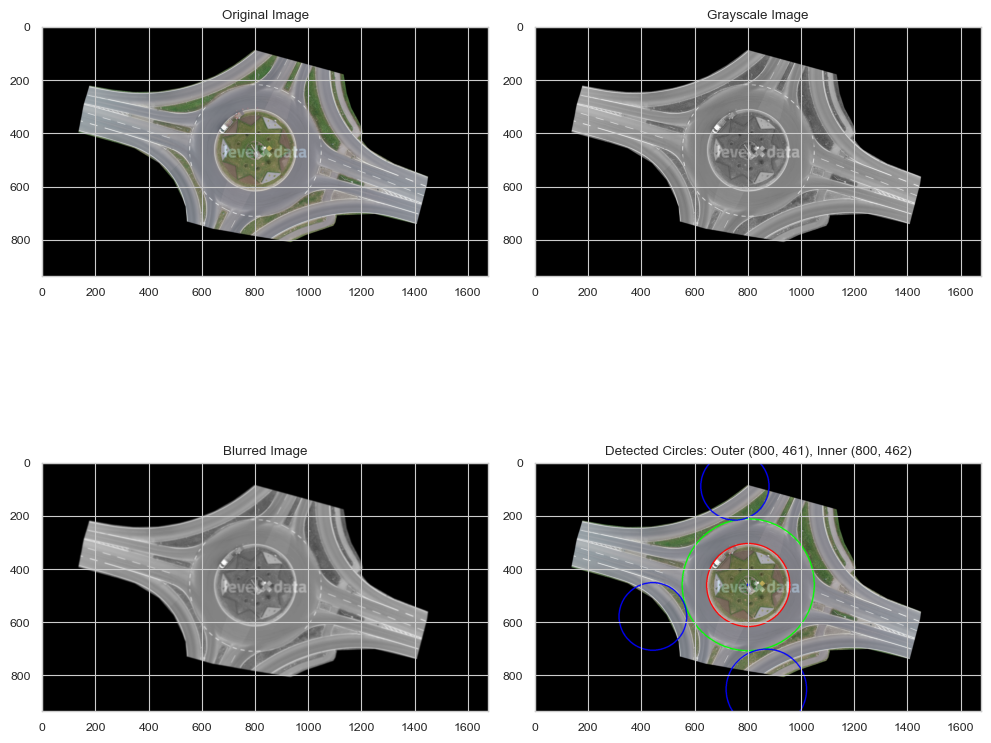

Filtering data with the following parameters:

Sampling period: 1000 ms Frame spacing: 25 frames 

Time elapsed is: 0.012874126434326172

In [19]:
if os.path.exists("/Users/lmiguelmartinez/Tesis/datasets/rounD/data/"):
    dataset_location = "/Users/lmiguelmartinez/Tesis/datasets/rounD/data/"
else:
    dataset_location = "/home/lmmartinez/Tesis/datasets/rounD/data/"

#dataset_index = 3
for dataset_index in range(1, 2):
    print("Processing dataset", dataset_index)
    start = time()
    scene_data = RounDGroupExtractor(dataset_location=dataset_location, dataset_index=dataset_index)
    end = time()
    print("Time elapsed is:", end - start)
    scene_data.get_roundabout_edges(plot_results=True)
    start = time()
    scene_data.filter_data(sampling_period=1000)
    end = time()
    print("Time elapsed is:", end - start)


In [20]:
scene_data.data.head()
print(scene_data.center_x_m, scene_data.center_y_m, scene_data.outer_radius_m, scene_data.inner_radius_m)

81.28121089327104 -46.83829777724743 25.19717537691402 15.849836124187851